In [ ]:
!pip install boto3
!pip install botocore

In [1]:
import zipfile
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from prettytable import PrettyTable
import shutil
import tensorflow as tf
import random
from PIL import Image
import boto3
from botocore.exceptions import ClientError
# from google.colab import userdata
import os
from concurrent.futures import ThreadPoolExecutor, as_completed
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()

2024-05-22 09:43:11.181863: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-22 09:43:11.181916: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-22 09:43:11.183638: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# Notebook Initialization

## Some constant

In [ ]:
# !rm -rf "/content/drive/MyDrive/written_number_classifier"

In [48]:
# constants to hold access key and id using environment variables

aws_access_key_id =  user_secrets.get_secret("AWS_ACCESS_KEY_ID")
aws_secret_access_key = user_secrets.get_secret("AWS_SECRET_ACCESS_KEY")

# Create an S3 resource with explicit credentials if provided
s3_resource = boto3.resource(
    's3', aws_access_key_id=aws_access_key_id,
    aws_secret_access_key=aws_secret_access_key
    )

In [ ]:
ROOT_DIR = '/content/drive/MyDrive/written_number_classifier'
DATA_SOURCE_DIR = os.path.join(ROOT_DIR,'Data_source')
DATAZIP_PATH = '/content/drive/MyDrive/data.zip'
PREDICTION_DATA_DIR = os.path.join(ROOT_DIR,'prediction_data')
BAD_IMAGE_DIR = os.path.join(ROOT_DIR,'bad_images')
RAW_IMAGES_STATISTICS = os.path.join(ROOT_DIR,'image_stats/stat.csv')

os.makedirs(ROOT_DIR,exist_ok=True)

ROOT_ARTIFACT = os.path.join(ROOT_DIR,"artifacts")
TRAIN_DATA_ARTIFACT = os.path.join(ROOT_ARTIFACT,'feature_store/train')
VALIDATION_DATA_ARTIFACT = os.path.join(ROOT_ARTIFACT,'feature_store/validation')
TEST_DATA_ARTIFACT = os.path.join(ROOT_ARTIFACT,'feature_store/test')
PREPROCESSED_IMAGES_STATISTICS = os.path.join(ROOT_ARTIFACT,'train_image_stats/stat.csv')
DATA_ARTIFACT_ZIP = 'data_artifact.zip'

## Some important functions and classes

### Class to analyze images

In [ ]:
class ImageDataAnalyzer:
    def __init__(self, image_df):
        """
        Initialize the ImageDataAnalyzer with a DataFrame containing image statistics.

        Parameters:
        - image_df (DataFrame): DataFrame containing image statistics.
        """
        self.image_df = image_df
        sns.set(style='whitegrid', palette='muted')

    def display_section_heading(self, heading):
        """
        Display a formatted section heading.

        Parameters:
        - heading (str): The heading text.

        Returns:
        - None
        """
        print("\n" + "-"*80 + f" {heading} " + "-"*80+ "\n")


    def calculate_total_image_statistics(self):
        """
        Calculate and display total image statistics.

        Returns:
        - None
        """
        total_images = len(self.image_df)
        max_images_label = self.image_df['Label'].value_counts().idxmax()
        max_images_count = self.image_df['Label'].value_counts().max()
        min_images_label = self.image_df['Label'].value_counts().idxmin()
        min_images_count = self.image_df['Label'].value_counts().min()
        median_images_count = np.median(self.image_df['Label'].value_counts())

        median_height = self.image_df['Height'].median()
        median_width = self.image_df['Width'].median()
        max_height = self.image_df['Height'].max()
        max_height_label = self.image_df.loc[self.image_df['Height'].idxmax(), 'Label']
        max_width = self.image_df['Width'].max()
        max_width_label = self.image_df.loc[self.image_df['Width'].idxmax(), 'Label']
        min_height = self.image_df['Height'].min()
        min_height_label = self.image_df.loc[self.image_df['Height'].idxmin(), 'Label']
        min_width = self.image_df['Width'].min()
        min_width_label = self.image_df.loc[self.image_df['Width'].idxmin(), 'Label']

        self.display_section_heading("Total Number of Images Statistics")

        total_images_table = PrettyTable(['Statistic', 'Value'])
        total_images_table.add_row(['Total Number of Images', f'{total_images}'])
        total_images_table.add_row(['Label with Max Images', f'{max_images_label}: {max_images_count}'])
        total_images_table.add_row(['Label with Min Images', f'{min_images_label}: {min_images_count}'])
        total_images_table.add_row(['Median Number of Images', f'{median_images_count:.2f}'])
        total_images_table.add_row(['Median Height', f'{median_height:.2f}'])
        total_images_table.add_row(['Median Width', f'{median_width:.2f}'])
        total_images_table.add_row(['Max Height', f'{max_height:.2f} ({max_height_label})'])
        total_images_table.add_row(['Max Width', f'{max_width:.2f} ({max_width_label})'])
        total_images_table.add_row(['Min Height', f'{min_height:.2f} ({min_height_label})'])
        total_images_table.add_row(['Min Width', f'{min_width:.2f} ({min_width_label})'])

        print(total_images_table)
        print()

    def plot_image_statistics(self):
        """
        Plot the distribution of number of pixels, file sizes, heights, and widths.

        Returns:
        - None
        """
        self.display_section_heading("Image Statistics Distribution")

        plt.figure(figsize=(16, 12))

        plt.subplot(2, 2, 1)
        sns.histplot(data=self.image_df, x='NumPixels', bins=30, kde=True, color='skyblue')
        plt.title('Distribution of Number of Pixels')
        plt.xlabel('Number of Pixels')
        plt.ylabel('Frequency')

        plt.subplot(2, 2, 2)
        sns.histplot(data=self.image_df, x='FileSizeIn_kb', bins=30, kde=True, color='salmon')
        plt.title('Distribution of File Sizes')
        plt.xlabel('File Size (KB)')
        plt.ylabel('Frequency')

        plt.subplot(2, 2, 3)
        sns.histplot(data=self.image_df, x='Width', bins=30, kde=True, color='lightgreen')
        plt.title('Distribution of Widths')
        plt.xlabel('Width (pixels)')
        plt.ylabel('Frequency')

        plt.subplot(2, 2, 4)
        sns.histplot(data=self.image_df, x='Height', bins=30, kde=True, color='lightcoral')
        plt.title('Distribution of Heights')
        plt.xlabel('Height (pixels)')
        plt.ylabel('Frequency')

        plt.tight_layout()
        plt.show()

    def boxplot_number_images_per_label(self):
        """
        Calculate and plot the number of images per label.

        Returns:
        - None
        """
        self.display_section_heading("Number of Images per Label")

        label_counts = self.image_df['Label'].value_counts()


        plt.figure(figsize=(12, 6))
        sns.boxplot(x=label_counts.index, y=label_counts.values, palette='viridis')
        plt.title('Number of Images per Label')
        plt.xlabel('Label')
        plt.ylabel('Count')
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.show()

    def calculate_label_wise_statistics(self):
        """
        Calculate and display label-wise image statistics.

        Returns:
        - None
        """
        label_stats = self.image_df.groupby('Label').agg({
            'Width': ['mean', 'median', 'min', 'max'],
            'Height': ['mean', 'median', 'min', 'max'],
            'NumPixels':['mean', 'median', 'min', 'max'],
            'FileSizeIn_kb': ['mean', 'median', 'min', 'max'],
            'Label': 'size'
        })
        label_stats.columns = ['Mean Width', 'Median Width', 'Min Width', 'Max Width',
                               'Mean Height', 'Median Height', 'Min Height', 'Max Height',
                               'Mean Pixels', 'Median Pixels', 'Min Pixels', 'Max Pixels',
                               'Mean File Size (KB)', 'Median File Size (KB)', 'Min File Size (KB)', 'Max File Size (KB)',
                               'Count']

        self.display_section_heading("Label-wise Image Statistics")

        label_stats_table = PrettyTable(['Label', 'Mean Width', 'Median Width', 'Min Width', 'Max Width',
                                         'Mean Height', 'Median Height', 'Min Height', 'Max Height',
                                         'Mean Pixels', 'Median Pixels', 'Min Pixels', 'Max Pixels',
                                        'Mean File Size (KB)', 'Median File Size (KB)', 'Min File Size (KB)', 'Max File Size (KB)',
                                        'Count'])

        for index, row in label_stats.iterrows():
            label_stats_table.add_row([index,f"{row['Mean Width']:.2f}", f"{row['Median Width']:.2f}",
                                       f"{row['Min Width']:.2f}", f"{row['Max Width']:.2f}",
                                       f"{row['Mean Height']:.2f}", f"{row['Median Height']:.2f}",
                                       f"{row['Min Height']:.2f}", f"{row['Max Height']:.2f}",
                                       f"{row['Mean Pixels']:.2f}", f"{row['Median Pixels']:.2f}",
                                       f"{row['Min Pixels']:.2f}", f"{row['Max Pixels']:.2f}",
                                       f"{row['Mean File Size (KB)']:.2f}", f"{row['Median File Size (KB)']:.2f}",
                                       f"{row['Min File Size (KB)']:.2f}", f"{row['Max File Size (KB)']:.2f}",
                                       f"{row['Count']}"])

        print(label_stats_table)



    def analyze(self):
        """
        Perform the complete analysis by calling all the required methods.

        Returns:
        - None
        """
        self.plot_image_statistics()
        # self.boxplot_number_images_per_label()
        self.calculate_label_wise_statistics()
        self.calculate_total_image_statistics()


### Functions

In [46]:


#######################################################################################################################################


def move_random_files(source_dir, dest_dir, percentage=20):
    """
    Moves a specified percentage of files from the source directory to the destination directory.
    If percentage is 100, copies all content from the source directory to the destination directory.

    Parameters:
    - source_dir (str): The path to the main directory containing the labeled subdirectories.
    - dest_dir (str): The path to the directory where the selected files will be moved.
    - percentage (int): The percentage of files to move. Default is 20%.
    """
    # Check if the destination directory is empty
    if os.listdir(dest_dir):
        print("Destination directory is not empty. Operation aborted.")
        return

    # Create destination folder if it doesn't exist
    os.makedirs(dest_dir, exist_ok=True)

    # If the percentage is 100, copy all contents from source_dir to dest_dir
    if percentage == 100:
        for item in os.listdir(source_dir):
            item_path = os.path.join(source_dir, item)
            if os.path.isdir(item_path):
                shutil.copytree(item_path, os.path.join(dest_dir, item), dirs_exist_ok=True)
            # else:
            #     shutil.copy2(item_path, dest_dir)
        print("All contents copied to destination directory.")
        return

    # Traverse the main directory to move files from each class directory
    for label in os.listdir(source_dir):
        label_path = os.path.join(source_dir, label)
        if os.path.isdir(label_path):
            # Create destination class directory
            dest_label_path = os.path.join(dest_dir, label)
            os.makedirs(dest_label_path, exist_ok=True)

            # Collect file paths from the current class directory
            file_paths = [os.path.join(label_path, file) for file in os.listdir(label_path)]

            # Shuffle the file paths randomly
            random.shuffle(file_paths)

            # Calculate the number of files to move
            num_to_move = int(len(file_paths) * (percentage / 100))

            # Move the selected files to the destination class directory
            for file in file_paths[:num_to_move]:
                dest_file_path = os.path.join(dest_label_path, os.path.basename(file))
                shutil.move(file, dest_file_path)

    print("Files moved successfully.")

##################################################################################################################################


def preprocessing(source_dir):
    """
    Processes all images in class folders within the source directory. Resizes and converts images to grayscale,
    then saves them back to their original locations.

    Parameters:
    - source_dir (str): The path to the main directory containing class subdirectories with images.
    """
    # Traverse the source directory
    for class_folder in os.listdir(source_dir):
        class_folder_path = os.path.join(source_dir, class_folder)
        if os.path.isdir(class_folder_path):
            # Process each image in the class folder
            for filename in os.listdir(class_folder_path):
                image_path = os.path.join(class_folder_path, filename)

                # Load the image
                image = tf.keras.utils.load_img(
                    path=image_path,
                    color_mode='grayscale',
                    target_size=(250, 250),
                    interpolation='nearest'
                    )
                image.save(image_path)

####################################################################################################################################


def augmentation(source_dir):

    """
    Balance each class by augmenting the images up to 20 images per class.

    Args:
    - source_dir (str): Path to the source directory containing class folders.
    - max_images_per_class (int): Maximum number of images per class after augmentation.

    Returns:
    None
    """

    # List of TensorFlow random augmentation functions
    random_augmentation_functions = [
    lambda image: tf.image.stateless_random_brightness(image=image, seed=(1,2), max_delta=0.3),
    lambda image: tf.image.stateless_random_contrast(image=image, seed=(1,2), lower=0.2, upper=0.5),
    lambda image: tf.image.flip_left_right(image=image),
    lambda image: tf.image.flip_up_down(image=image),
    lambda image: tf.image.rot90(image, k=1),
    ]

    # Traverse the source directory
    for class_folder in os.listdir(source_dir):
        class_folder_path = os.path.join(source_dir, class_folder)
        if os.path.isdir(class_folder_path):
            for images in os.listdir(class_folder_path):
                img_path = os.path.join(class_folder_path,images)
                image = tf.keras.utils.load_img(
                    path=img_path,
                    color_mode='rgb',
                    target_size=(300, 300,3),
                    interpolation='nearest'
                    )
                image=tf.keras.preprocessing.image.img_to_array(image)

                # Apply random augmentation
                for i in range(2):
                    choice = random.randint(0,len(random_augmentation_functions)-1)
                    augmented_image = random_augmentation_functions[choice](image)
                    augmented_image=tf.cast(augmented_image, tf.uint8)

                    # Convert image back to uint8 and save as PNG in the same directory
                    augmented_image = Image.fromarray(augmented_image.numpy().reshape(300,300,3))
                    augmented_img_path = os.path.join(class_folder_path, f"aug{i}_{images}")
                    augmented_image.save(augmented_img_path)

                print(f"Augmented and saved image: {augmented_img_path}")


#############################################################################################################################################################


def gather_image_statistics(main_dir, output_dir, bad_images_dir):
    """
    Gather statistics for images in the specified directory.

    Args:
    - main_dir (str): Path to the main directory containing class folders.
    - output_dir (str): Path to the directory where the CSV file with statistics will be saved.
    - bad_images_dir (str): Path to the directory where bad images will be moved.

    Returns:
    None
    """
    image_data = []

    # Traverse the main directory to gather statistics
    for label in os.listdir(main_dir):
        label_path = os.path.join(main_dir, label)
        if os.path.isdir(label_path):  # Ensure it's a directory
            label_images = [img for img in os.listdir(label_path)]

            # Gather image statistics
            for i, img_file in enumerate(label_images):
                img_path = os.path.join(label_path, img_file)
                try:
                    with Image.open(img_path) as img:
                        width, height = img.size
                        num_pixels = width * height
                        file_size = os.path.getsize(img_path) / 1000  # Size in kilobytes
                        image_data.append({
                            'Label': label,
                            'Filename': img_file,
                            'Width': width,
                            'Height': height,
                            'NumPixels': num_pixels,
                            'FileSizeIn_kb': file_size
                        })
                except Exception as e:
                    print(f"Error processing {img_path}: {e}")
                    # Move the rejected file to the bad images folder
                    # os.makedirs(bad_images_dir, exist_ok=True)
                    # dest_path = os.path.join(bad_images_dir, f'{label}_{img_file}')
                    # os.rename(img_path, dest_path)

        print("work in progress...")

    # Create a DataFrame
    image_df = pd.DataFrame(image_data)

    # Display the statistics
    print("DataFrame with image statistics:")
    print(image_df.head())

    # Create the directory to save image statistics CSV if it doesn't exist

    os.makedirs(os.path.dirname(output_dir), exist_ok=True)

    # Save the DataFrame to a CSV file
    image_df.to_csv(output_dir, index=False)

##########################################################################################################################################

import zipfile
import os

def unzip_folder(zip_path, dest_folder):
    """
    Unzips a folder to a destination folder.

    Args:
        zip_path: Path to the ZIP file.
        dest_folder: Path to the destination folder.

    Returns:
        None
    """
    # Ensure the ZIP file exists
    if not os.path.exists(zip_path):
        print(f"Error: ZIP file '{zip_path}' not found.")
        return

    # Ensure the destination folder path is absolute
    dest_folder = os.path.abspath(dest_folder)

    # Create the destination folder if it doesn't exist
    os.makedirs(dest_folder, exist_ok=True)

    # Unzip the ZIP file
    with zipfile.ZipFile(zip_path, 'r') as zipf:
        zipf.extractall(dest_folder)

    print(f"ZIP file '{zip_path}' unzipped successfully to '{dest_folder}'.")

############################################################################################################################

def upload_file_to_s3( s3_resource,bucket_name,local_path,s3_path):
    bucket = s3_resource.Bucket(bucket_name)
    try:
        bucket.upload_file(local_path, s3_path)
        print(f'Successfully uploaded {local_path} to s3://{bucket.name}/{s3_path}')
    except FileNotFoundError:
        print(f'The file was not found: {local_path}')
    except boto3.exceptions.S3UploadFailedError as e:
        print(f'Failed to upload {local_path} to {s3_path}: {e}')

####################################################################################################################################

import boto3

def upload_file_to_s3(file_name,s3_resource, bucket_name, object_name=None):
    """
    Upload a file to an S3 bucket

    :param file_name: File to upload
    :param bucket_name: Bucket to upload to
    :param object_name: S3 object name. If not specified then file_name is used
    :return: True if file was uploaded, else False
    """
    # If S3 object_name was not specified, use file_name
    if object_name is None:
        object_name = file_name

    # Upload the file
    try:
        s3_resource.Bucket(bucket_name).upload_file(file_name, object_name)
        print(f"File {file_name} uploaded to {bucket_name}/{object_name}")
        return True
    except Exception as e:
        print(f"Error uploading file: {e}")
        return False



######################################################################################################################################

def upload_directory_to_s3(local_directory, s3_resource, bucket_name, s3_directory):
    bucket = s3_resource.Bucket(bucket_name)

    # Collect all files to upload
    files_to_upload = []
    for root, dirs, files in os.walk(local_directory):
        for file in files:
            local_path = os.path.join(root, file)
            relative_path = os.path.relpath(local_path, local_directory)
            s3_path = os.path.join(s3_directory, relative_path).replace("\\", "/")
            files_to_upload.append((local_path, s3_path))

    # Use ThreadPoolExecutor for concurrent uploading
    with ThreadPoolExecutor() as executor:
        futures = []
        for local_path, s3_path in files_to_upload:
            futures.append(executor.submit(upload_file, local_path, bucket, s3_path))

        # Process results
        for future in as_completed(futures):
            try:
                future.result()
            except Exception as e:
                print(f'An error occurred: {e}')
#######################################################################################################################

import os
import zipfile

def zip_directory(directory_path, zip_file_path):
    """
    Zip a directory recursively.

    Args:
    - directory_path: Path to the directory to be zipped.
    - zip_file_path: Path to the resulting zip file.

    Returns:
    - True if zipping was successful, False otherwise.
    """
    try:
        with zipfile.ZipFile(zip_file_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
            for root, dirs, files in os.walk(directory_path):
                for file in files:
                    file_path = os.path.join(root, file)
                    zipf.write(file_path, os.path.relpath(file_path, directory_path))

        print(f"Directory zipped successfully. Zip file saved at: {zip_file_path}")
        return True
    except Exception as e:
        print(f"Error zipping directory: {e}")
        return False

###############################################################################################################



def download_directory_from_s3(s3_resource, bucket_name, s3_directory, local_directory):
    """
    Download a directory from S3 to a local directory recursively using Boto3 Resource.

    Args:
    - s3_resource: Boto3 S3 Resource.
    - bucket_name: Name of the S3 bucket.
    - s3_directory: Directory (prefix) in S3 to download.
    - local_directory: Local directory to download files to.
    """

    # Create the local directory if it doesn't exist
    os.makedirs(local_directory, exist_ok=True)

    # S3 bucket object
    bucket = s3_resource.Bucket(bucket_name)

    # List all objects in the S3 directory
    for obj in bucket.objects.filter(Prefix=s3_directory):
        # Construct the local file path
        local_file_path = os.path.join(local_directory, os.path.relpath(obj.key, s3_directory))

        # Create the local directory if it doesn't exist
        os.makedirs(os.path.dirname(local_file_path), exist_ok=True)

        # Download the file from S3
        bucket.download_file(obj.key, local_file_path)

        print(f"Downloaded {obj.key} to {local_file_path}")

    print(f"Download of directory {s3_directory} complete.")


#################################################################################################################################


def download_file_from_s3(s3_resource,bucket_name, object_name, file_name):
    """
    Download a file from an S3 bucket

    :param bucket_name: Name of the S3 bucket
    :param object_name: Name of the object in S3
    :param file_name: Name of the file to save as locally
    :return: True if file was downloaded, else False
    """

    # Download the file
    try:
        s3_resource.Bucket(bucket_name).download_file(object_name, file_name)
        print(f"File {object_name} from bucket {bucket_name} downloaded as {file_name}")
        return True
    except Exception as e:
        print(f"Error downloading file: {e}")
        return False

# Data Ingestion Workflow

## Unzipping data and saving it to destination folder

In [ ]:
!rm -rf /content/Data_source

In [ ]:
unzip_folder(zip_path=DATAZIP_PATH,
             dest_folder=ROOT_DIR
             )

## Studing image statistics

In [ ]:
# getting image stat of train data
gather_image_statistics(main_dir=DATA_SOURCE_DIR,
                        output_dir=RAW_IMAGES_STATISTICS,
                        bad_images_dir=BAD_IMAGE_DIR)

In [ ]:
df = pd.read_csv(RAW_IMAGES_STATISTICS)
df

In [ ]:
ImageDataAnalyzer(df).analyze()

## Spliting train and validation Preprocessing and augemneting images and save it as artifact

In [ ]:
!rm -rf /content/drive/MyDrive/written_number_classifier/artifacts

In [ ]:
# create atifact folder if not present
os.makedirs(TRAIN_DATA_ARTIFACT,exist_ok=True)
os.makedirs(VALIDATION_DATA_ARTIFACT,exist_ok=True)
os.makedirs(TEST_DATA_ARTIFACT,exist_ok=True)

In [ ]:
# copying all contents of From data source to train data artifact
move_random_files(source_dir=DATA_SOURCE_DIR , dest_dir=TRAIN_DATA_ARTIFACT, percentage=100)

# moving 20 percent of train data for validation
move_random_files(source_dir=TRAIN_DATA_ARTIFACT, dest_dir=VALIDATION_DATA_ARTIFACT, percentage=20)

# moving 20 percent of train data for prediction/ TEST
move_random_files(source_dir=TRAIN_DATA_ARTIFACT, dest_dir=TEST_DATA_ARTIFACT, percentage=20)

In [ ]:
# Augmenting train data
augmentation(source_dir=TRAIN_DATA_ARTIFACT)

#### Analysing prepocessed and augmented train images

In [ ]:
# getting image stat of train data
gather_image_statistics(main_dir=TRAIN_DATA_ARTIFACT,
                        output_dir=PREPROCESSED_IMAGES_STATISTICS,
                        bad_images_dir='')


In [ ]:
df = pd.read_csv(PREPROCESSED_IMAGES_STATISTICS)
df

In [ ]:
ImageDataAnalyzer(df).analyze()

## Zipping and uploading artifacts to s3 for later use



In [ ]:
# zipping the artifact
zip_directory(directory_path =ROOT_ARTIFACT,
              zip_file_path=DATA_ARTIFACT_ZIP)


In [ ]:
upload_file_to_s3(
    local_path=DATA_ARTIFACT_ZIP,
    bucket_name='written-number-classifier',
    s3_path='artifact/data_artifact/data_artifact.zip',
    s3_resource=s3_resource
    )

# Training work Flow

In [ ]:
!rm -rf /content/drive/MyDrive/written_number_classifier

In [ ]:
!rm -rf /kaggle/working/artifacts/model/working.model.keras

## Some constants related to training workflow

## Download data artifact zip and unzipping it for training phase

In [ ]:
# downloading data artifact zip
download_file_from_s3(
    s3_resource,
    'written-number-classifier',
    'artifact/data_artifact/data_artifact.zip',
    DATA_ARTIFACT_ZIP
    )

In [ ]:
# unzipping data artifacr zip
unzip_folder(DATA_ARTIFACT_ZIP,'')

## Converting the images to tf.data.dataset for training

In [12]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DATA_ARTIFACT,
    seed=123,
    batch_size=128,
    color_mode="grayscale",
    image_size=(256, 256),
    shuffle=True,
    # validation_split=0.3,
    # subset='training',
  )

val_ds = tf.keras.utils.image_dataset_from_directory(
    VALIDATION_DATA_ARTIFACT,
    seed=123,
    batch_size=128,
    color_mode="grayscale",
    image_size=(256, 256),
    shuffle=True,
    # validation_split=0.3,
    # subset='validation'
  )

# train_ds.save(TRAIN_DATA_ARTIFACT)
# val_ds.save(VALIDATION_DATA_ARTIFACT)

Found 19200 files belonging to 100 classes.
Found 2000 files belonging to 100 classes.


In [13]:
class_names = train_ds.class_names
print(class_names)

['eight', 'eighteen', 'eighty', 'eighty eight', 'eighty five', 'eighty four', 'eighty nine', 'eighty one', 'eighty seven', 'eighty six', 'eighty three', 'eighty two', 'eleven', 'fifteen', 'fifty', 'fifty eight', 'fifty five', 'fifty four', 'fifty nine', 'fifty one', 'fifty seven', 'fifty six', 'fifty three', 'fifty two', 'five', 'forty', 'forty eight', 'forty five', 'forty four', 'forty nine', 'forty one', 'forty seven', 'forty six', 'forty three', 'forty two', 'four', 'fourteen', 'hundred', 'nine', 'nineteen', 'ninety', 'ninety eight', 'ninety five', 'ninety four', 'ninety nine', 'ninety one', 'ninety seven', 'ninety six', 'ninety three', 'ninety two', 'one', 'seven', 'seventeen', 'seventy', 'seventy eight', 'seventy five', 'seventy four', 'seventy nine', 'seventy one', 'seventy seven', 'seventy six', 'seventy three', 'seventy two', 'six', 'sixteen', 'sixty', 'sixty eight', 'sixty five', 'sixty four', 'sixty nine', 'sixty one', 'sixty seven', 'sixty six', 'sixty three', 'sixty two', '

In [21]:
save_class_labels(class_names, LABEL_ARTIFACT)

In [24]:
import json

def save_class_labels(lst, filename):
    """
    Serialize a list of class labels into a JSON file.

    Args:
        lst (list): The list of class labels.
        filename (str): The filename for the JSON file.

    Returns:
        None
    """
    # Creating the mapped dictionary
    mapped_dict = {i: lst[i] for i in range(len(lst))}
    
    
    os.makedirs(os.path.dirname(filename),exist_ok = True)
    
    # Serialize the dictionary to JSON
    with open(filename, 'w') as f:
        json.dump(mapped_dict, f)


In [25]:
import json

def read_class_labels(filename):
    """
    Read class labels from a JSON file.

    Args:
        filename (str): The filename of the JSON file.

    Returns:
        dict: A dictionary containing the class labels.
    """
    with open(filename, 'r') as f:
        class_labels = json.load(f)
    return class_labels


In [26]:
# Example usage
class_labels = read_class_labels(LABEL_ARTIFACT)
print(class_labels)

{'0': 'eight', '1': 'eighteen', '2': 'eighty', '3': 'eighty eight', '4': 'eighty five', '5': 'eighty four', '6': 'eighty nine', '7': 'eighty one', '8': 'eighty seven', '9': 'eighty six', '10': 'eighty three', '11': 'eighty two', '12': 'eleven', '13': 'fifteen', '14': 'fifty', '15': 'fifty eight', '16': 'fifty five', '17': 'fifty four', '18': 'fifty nine', '19': 'fifty one', '20': 'fifty seven', '21': 'fifty six', '22': 'fifty three', '23': 'fifty two', '24': 'five', '25': 'forty', '26': 'forty eight', '27': 'forty five', '28': 'forty four', '29': 'forty nine', '30': 'forty one', '31': 'forty seven', '32': 'forty six', '33': 'forty three', '34': 'forty two', '35': 'four', '36': 'fourteen', '37': 'hundred', '38': 'nine', '39': 'nineteen', '40': 'ninety', '41': 'ninety eight', '42': 'ninety five', '43': 'ninety four', '44': 'ninety nine', '45': 'ninety one', '46': 'ninety seven', '47': 'ninety six', '48': 'ninety three', '49': 'ninety two', '50': 'one', '51': 'seven', '52': 'seventeen', '

In [52]:
# pushing the labbel to S3
upload_file_to_s3(file_name=LABEL_ARTIFACT,
                  s3_resource=s3_resource,
                  bucket_name='written-number-classifier',
                  object_name=S3_LABEL_ARTIFACT_PATH
                  )

File artifacts/labels/labels.json uploaded to written-number-classifier/artifact/label-artifact/labels.json


True

## Fine Tuning

In [ ]:
# List available physical devices
physical_devices = tf.config.list_physical_devices()
print("Available physical devices:", physical_devices)

# Check specifically for GPUs
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPUs detected: {gpus}")
else:
    print("No GPUs detected.")


In [ ]:
base_model = tf.keras.applications.EfficientNetB7(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(256, 256, 3),
    include_top=False,
    pooling='average'
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = tf.keras.Input(shape=(256, 256, 1))

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(inputs,training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
# x = tf.keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = tf.keras.layers.Dense(100)(x)
model = tf.keras.Model(inputs, outputs)

model.summary(show_trainable=True)

In [43]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

# Define the number of epochs
epochs = 100

# Set up TensorBoard callback with histogram_freq
tensorboard_callback = TensorBoard(log_dir= TRAINING_LOG_DIR, histogram_freq=1)

# Set up EarlyStopping callback
early_stopping_callback = EarlyStopping(
    monitor='val_sparse_categorical_accuracy',  # Metric to monitor
    patience=10,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Whether to restore model weights from the epoch with the best value of the monitored quantity
)

# Set up ModelCheckpoint callback with formatted filepath
checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(CHECKPOINT_DIR,'{epoch:02d}-{val_loss:.2f}.h5'),  # Filepath to save the model
    monitor='val_sparse_categorical_accuracy',  # Metric to monitor
    save_best_only=True  # Save only the best model
)

# Set up ReduceLROnPlateau callback
reduce_lr_callback = ReduceLROnPlateau(
    monitor='val_sparse_categorical_accuracy',  # Metric to monitor
    factor=0.2,  # Factor by which the learning rate will be reduced
    patience=3,  # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=0.0001  # Lower bound on the learning rate
)

# Combine all callbacks
callbacks = [tensorboard_callback, early_stopping_callback, checkpoint_callback, reduce_lr_callback]

# Ensure the checkpoint and log directory exists
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
os.makedirs(TRAINING_LOG_DIR, exist_ok=True)

# To start TensorBoard, run the following command in your terminal:
# tensorboard --logdir=./logs


In [ ]:
print("Fitting the top layer of the model")
model.fit(train_ds, epochs=epochs, validation_data=val_ds,callbacks=callbacks)

## Trainining stopped due colab GPU limit so best trained model is pushed to the S3 for reloading and training will restat from there using kaggle notebook

In [49]:
# pushing the best model to S3
upload_file_to_s3(file_name='/content/drive/MyDrive/written_number_classifier/model_checkpoints/10-2.29.keras',
                  s3_resource=s3_resource,
                  bucket_name='written-number-classifier',
                  object_name='artifact/model-artiact/best_model.keras'
                  )

Error uploading file: [Errno 2] No such file or directory: '/content/drive/MyDrive/written_number_classifier/model_checkpoints/10-2.29.keras'


False

## Restarting the training in kaggle by loading the best model till now from S3

In [61]:
import keras
# print(keras.__version__)
# !pip install keras==2.15.0
print(keras.__version__)
# !pip show tensorflow
print(tf.__version__)

2.15.0
2.15.0


In [ ]:
# create model artifact directory
os.makedirs(MODEL_ARTIFACT,exist_ok=True)

In [53]:
# downloading the model from s3
download_file_from_s3(
    s3_resource,
    'written-number-classifier',
    S3_MODEL_ARTIFACT_PATH,
    os.path.join(MODEL_ARTIFACT,'working_model.keras')
    )

File artifact/model-artiact/best_model.keras from bucket written-number-classifier downloaded as artifacts/model/working_model.keras


True

In [55]:
## loading the model
model = tf.keras.models.load_model(os.path.join(MODEL_ARTIFACT,'working_model.keras'))
# model = tf.keras.models.load_model('/kaggle/working/model_checkpoints/11-0.97.keras')


In [9]:
model.summary(show_trainable=True)

Model: "model_1"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_4 (InputLayer)        [(None, 256, 256, 1)]     0         Y          
                                                                            
 efficientnetb7 (Functional  (None, 8, 8, 2560)        6409768   Y          
 )                                                     7                    
                                                                            
 global_average_pooling2d_1  (None, 2560)              0         Y          
  (GlobalAveragePooling2D)                                                  
                                                                            
 dense_1 (Dense)             (None, 100)               256100    Y          
                                                                            
Total params: 64353787 (245.49 MB)
Trainable params: 256100

In [ ]:
model.fit(train_ds, epochs=epochs, validation_data=val_ds,callbacks=callbacks)

In [51]:
# pushing the best model to S3
upload_file_to_s3(file_name='/kaggle/working/model_checkpoints/03-0.95.h5',
                  s3_resource=s3_resource,
                  bucket_name='written-number-classifier',
                  object_name='artifact/model-artiact/best_model.h5'
                  )

File /kaggle/working/model_checkpoints/03-0.95.h5 uploaded to written-number-classifier/artifact/model-artiact/best_model.h5


True

## Prparing the model for inferencing and pushing it s3 model registory

In [69]:
model = model = tf.keras.models.load_model('/kaggle/working/model_checkpoints/46-0.88.keras')

In [70]:
# adding softmax layer to predict probablities of class labels
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])
# saving model in local model registry
probability_model.save(MODEL_REGISTRY)

In [71]:
# pushing the prod model to S3 remote registry
upload_file_to_s3(file_name=MODEL_REGISTRY,
                  s3_resource=s3_resource,
                  bucket_name='written-number-classifier',
                  object_name=MODEL_REGISTRY
                  )

File model_registry/prod_model.h5 uploaded to written-number-classifier/model_registry/prod_model.h5


True

## Testing inference

In [ ]:
import keras
print(keras.__version__)

In [ ]:
!pip show tensorflow

In [4]:
from pathlib import Path

image = tf.keras.utils.load_img(
                    path=Path("/kaggle/working/artifacts/feature_store/test/forty six/image_93.png"),
                    color_mode='grayscale',
                    target_size=(256,256,1),
                    interpolation='nearest'
                    )


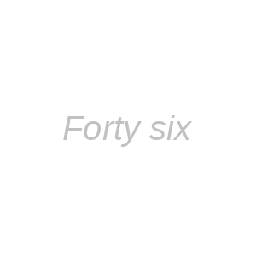

In [5]:
image

In [6]:
image=np.array(image).reshape(1,256,256,1)
image

array([[[[255],
         [255],
         [255],
         ...,
         [255],
         [255],
         [255]],

        [[255],
         [255],
         [255],
         ...,
         [255],
         [255],
         [255]],

        [[255],
         [255],
         [255],
         ...,
         [255],
         [255],
         [255]],

        ...,

        [[255],
         [255],
         [255],
         ...,
         [255],
         [255],
         [255]],

        [[255],
         [255],
         [255],
         ...,
         [255],
         [255],
         [255]],

        [[255],
         [255],
         [255],
         ...,
         [255],
         [255],
         [255]]]], dtype=uint8)

In [58]:
pred = probability_model.predict(image)

1/1 [==============================] - 5s 5s/step


In [59]:
pred_idx = np.argmax(pred)
type(pred_idx)

numpy.int64

In [32]:
class_labels = read_class_labels(LABEL_ARTIFACT)
print(class_labels)

{'0': 'eight', '1': 'eighteen', '2': 'eighty', '3': 'eighty eight', '4': 'eighty five', '5': 'eighty four', '6': 'eighty nine', '7': 'eighty one', '8': 'eighty seven', '9': 'eighty six', '10': 'eighty three', '11': 'eighty two', '12': 'eleven', '13': 'fifteen', '14': 'fifty', '15': 'fifty eight', '16': 'fifty five', '17': 'fifty four', '18': 'fifty nine', '19': 'fifty one', '20': 'fifty seven', '21': 'fifty six', '22': 'fifty three', '23': 'fifty two', '24': 'five', '25': 'forty', '26': 'forty eight', '27': 'forty five', '28': 'forty four', '29': 'forty nine', '30': 'forty one', '31': 'forty seven', '32': 'forty six', '33': 'forty three', '34': 'forty two', '35': 'four', '36': 'fourteen', '37': 'hundred', '38': 'nine', '39': 'nineteen', '40': 'ninety', '41': 'ninety eight', '42': 'ninety five', '43': 'ninety four', '44': 'ninety nine', '45': 'ninety one', '46': 'ninety seven', '47': 'ninety six', '48': 'ninety three', '49': 'ninety two', '50': 'one', '51': 'seven', '52': 'seventeen', '

In [60]:
class_labels[str(pred_idx)]

'forty six'

In [62]:
!python --version

Python 3.10.13


In [73]:
from IPython.display import FileLink
FileLink(r'model_registry/prod_model.h5')


/kaggle/working/model_registry/prod_model.h5

In [65]:
FileLink(r'artifacts/labels/labels.json')

/kaggle/working/artifacts/labels/labels.json